# Positie van de maan en zon bepalen
Die twee zijn, 99%(bereken het zelf, ik ben lui) van de zwaartekracht gradient.

Nogal veel gedoe om dat allemaal zelf uit te zoeken, dus een library.

## Idee: gebruik [`astropy`](http://astropy.org/)

Begon ermee te rommelen om uit te zoeken. Maar het is veel te traag..

[Dit voorbeeld](http://docs.astropy.org/en/stable/_modules/astropy/coordinates/solar_system.html) gedownload,
en dat lijkt veel minder traag door numpy te gebruiken.

In [1]:
import astropy
from astropy.coordinates import EarthLocation, SkyCoord, AltAz

Centrum van de aarde later nodig omdat die relevant is voor de andere analyse.

In [2]:
EarthLocation.from_geocentric(0,0,0, 'm')

<EarthLocation (0., 0., 0.) m>

Beter als astro *voorbeeld* om Amsterdam te pakken. (code niet nodig)

In [3]:
import geopandas as gpd
city_tab = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
where = city_tab[city_tab.name=='Amsterdam'].geometry

(float(where.x), float(where.y))
# TODO astropy.coordinates.EarthLocation.from_geocentric(0,0,0, 'm')

(4.914694317400972, 52.35191454666443)

In [4]:
pos = EarthLocation.from_geodetic(4.914694317400972, 52.35191454666443)

In [5]:
import time
def astro_t(t): return astropy.time.Time(format='unix', val=t)

In [6]:
astropy.coordinates.solar_system.get_body('mars', astro_t(time.time()), pos)

<SkyCoord (GCRS: obstime=1520427028.9050598, obsgeoloc=(3909079.43495258, 169906.69081299, 5020016.10808304) m, obsgeovel=(-12.40147172, 284.41616249, 0.03061264) m / s): (ra, dec, distance) in (deg, deg, AU)
    (263.31135661, -23.12147619, 1.33908909)>

In [7]:
astropy.coordinates.solar_system.get_body('mars', astro_t(time.time()+3600), pos)

<SkyCoord (GCRS: obstime=1520430629.8308637, obsgeoloc=(3731241.4741898, 1176509.90252796, 5020357.91034476) m, obsgeovel=(-85.80391079, 271.44797658, 0.15813599) m / s): (ra, dec, distance) in (deg, deg, AU)
    (263.33793312, -23.12322374, 1.33869523)>

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
def rangef(f,t,s):
    x, s = f, s or 1
    while x < t:
        yield x
        x = x + s
    if x != t: yield(t)

Het zijn er maar 144 maar is ongelofelijk traag..

In [10]:
venus = astropy.coordinates.solar_system.get_body('venus', astro_t(time.time()), pos)

def venus_t(t):
    t = astro_t(t)
    c = venus.transform_to(AltAz(obstime=t, location=pos))
    return c.az.value, c.alt.value

day_s = 3600*24
def t_range(): return rangef(time.time(), time.time() + day_s, 600)
coords = [venus_t(t) for t in t_range()]
len(coords)

146

In [11]:
def split_pair(list):
    ret = ([],[])
    for el in list:
        ret[0].append(el[0])
        ret[1].append(el[1])
    return ret

Een dag, lijn aan de linkerkant is een illusie(360&rarr;0)

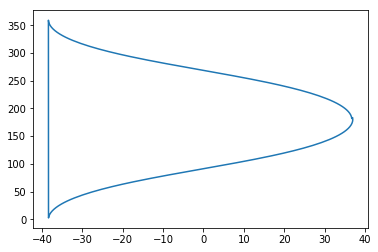

In [12]:
lat, lon = split_pair(coords)
plt.plot(lon, lat)

### Sneller

[Dit voorbeeld](http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html#sphx-glr-generated-examples-coordinates-plot-obs-planning-py)([ipynb](http://docs.astropy.org/en/stable/_downloads/plot_obs-planning.ipynb)) runde een stuk sneller.. Het verschil is dat het met `np.linspace` een heel array tegelijk geeft. Aangepast..

In [13]:
import numpy as np

In [14]:
from astropy.coordinates import get_sun
import astropy.units as u

times = astropy.time.Time('2012-7-13 00:00:00') + np.linspace(-12, 12, 1000)*u.hour

sun = get_sun(times).transform_to(AltAz(obstime=times, location=pos))
venus_p = venus.transform_to(AltAz(obstime=times, location=pos))

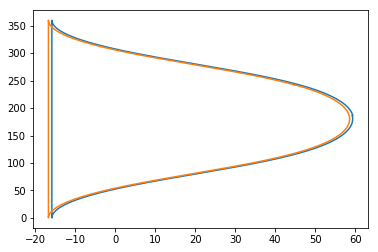

In [15]:
plt.plot(sun.alt, sun.az)
plt.plot(venus_p.alt, venus_p.az)

Moet zeggen dat ik het niet snap. Waarom *moet* de positie/tijd bij het object gespecificeert worden..

    venus = astropy.coordinates.solar_system.get_body('venus', astro_t(time.time()), pos)

En dan weer.

    venus.transform_to(AltAz(obstime=t, location=pos))

En ook `astropy.time.Time`.. Neemt geen unix tijden aan. Okey, ik zou dit sort-of logisch vinden
*als* niet wel strings aan nam... (i.e. al dat soort zooi defereren naar een tijd-lib.)

### Tuurlijk ook afstand

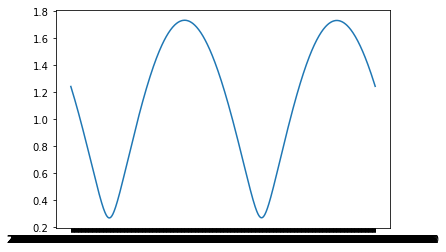

In [16]:
times_2 = astropy.time.Time('2012-7-13 00:00:00') + np.linspace(-1, 1, 1000)*u.year

venus_p2 = venus.transform_to(AltAz(obstime=times_2, location=pos))

plt.plot(venus_p2.obstime.value, venus_p2.distance.AU)